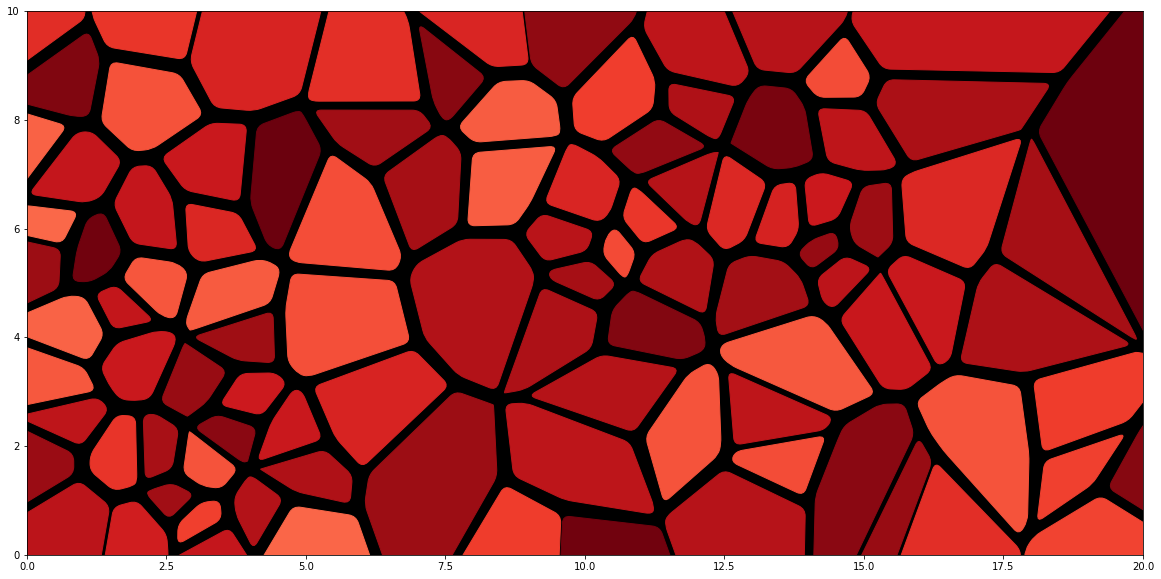

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import patches, path
from scipy.spatial import Voronoi, voronoi_plot_2d


def shrink(polygon, pad):
    center = np.mean(polygon, axis=0)
    resized = np.zeros_like(polygon)
    for ii, point in enumerate(polygon):
        vector = point - center
        unit_vector = vector / np.linalg.norm(vector)
        resized[ii] = point - pad * unit_vector
    return resized


class RoundedPolygon(patches.PathPatch):
    # https://stackoverflow.com/a/66279687/2912349
    def __init__(self, xy, pad, **kwargs):
        p = path.Path(*self.__round(xy=xy, pad=pad))
        super().__init__(path=p, **kwargs)

    def __round(self, xy, pad):
        n = len(xy)

        for i in range(0, n):

            x0, x1, x2 = np.atleast_1d(xy[i - 1], xy[i], xy[(i + 1) % n])

            d01, d12 = x1 - x0, x2 - x1
            l01, l12 = np.linalg.norm(d01), np.linalg.norm(d12)
            u01, u12 = d01 / l01, d12 / l12

            x00 = x0 + min(pad, 0.5 * l01) * u01
            x01 = x1 - min(pad, 0.5 * l01) * u01
            x10 = x1 + min(pad, 0.5 * l12) * u12
            x11 = x2 - min(pad, 0.5 * l12) * u12

            if i == 0:
                verts = [x00, x01, x1, x10]
            else:
                verts += [x01, x1, x10]

        codes = [path.Path.MOVETO] + n*[path.Path.LINETO, path.Path.CURVE3, path.Path.CURVE3]

        verts[0] = verts[-1]

        return np.atleast_1d(verts, codes)


if __name__ == '__main__':

    # make up data points
    n = 100
    max_x = 20
    max_y = 10
    points = np.c_[np.random.uniform(0, max_x, size=n),
                   np.random.uniform(0, max_y, size=n)]

    # add 4 distant dummy points
    points = np.append(points, [[2 * max_x, 2 * max_y],
                                [   -max_x, 2 * max_y],
                                [2 * max_x,    -max_y],
                                [   -max_x,    -max_y]], axis = 0)

    # compute Voronoi tesselation
    vor = Voronoi(points)

    fig, ax = plt.subplots(figsize=(max_x, max_y))
    for region in vor.regions:
        if region and (not -1 in region):
            polygon = np.array([vor.vertices[i] for i in region])
            resized = shrink(polygon, 0.15)
            ax.add_patch(RoundedPolygon(resized, max(max_x, max_y) / 150, color=plt.cm.Reds(0.5 + 0.5*np.random.rand())))

    ax.axis([0, max_x, 0, max_y])
    ax.set_facecolor('black')
    ax.add_artist(ax.patch)
    ax.patch.set_zorder(-1)
    plt.show()

(1440, 2160)
max x, max y 2160 1440
min_shrink 10.8


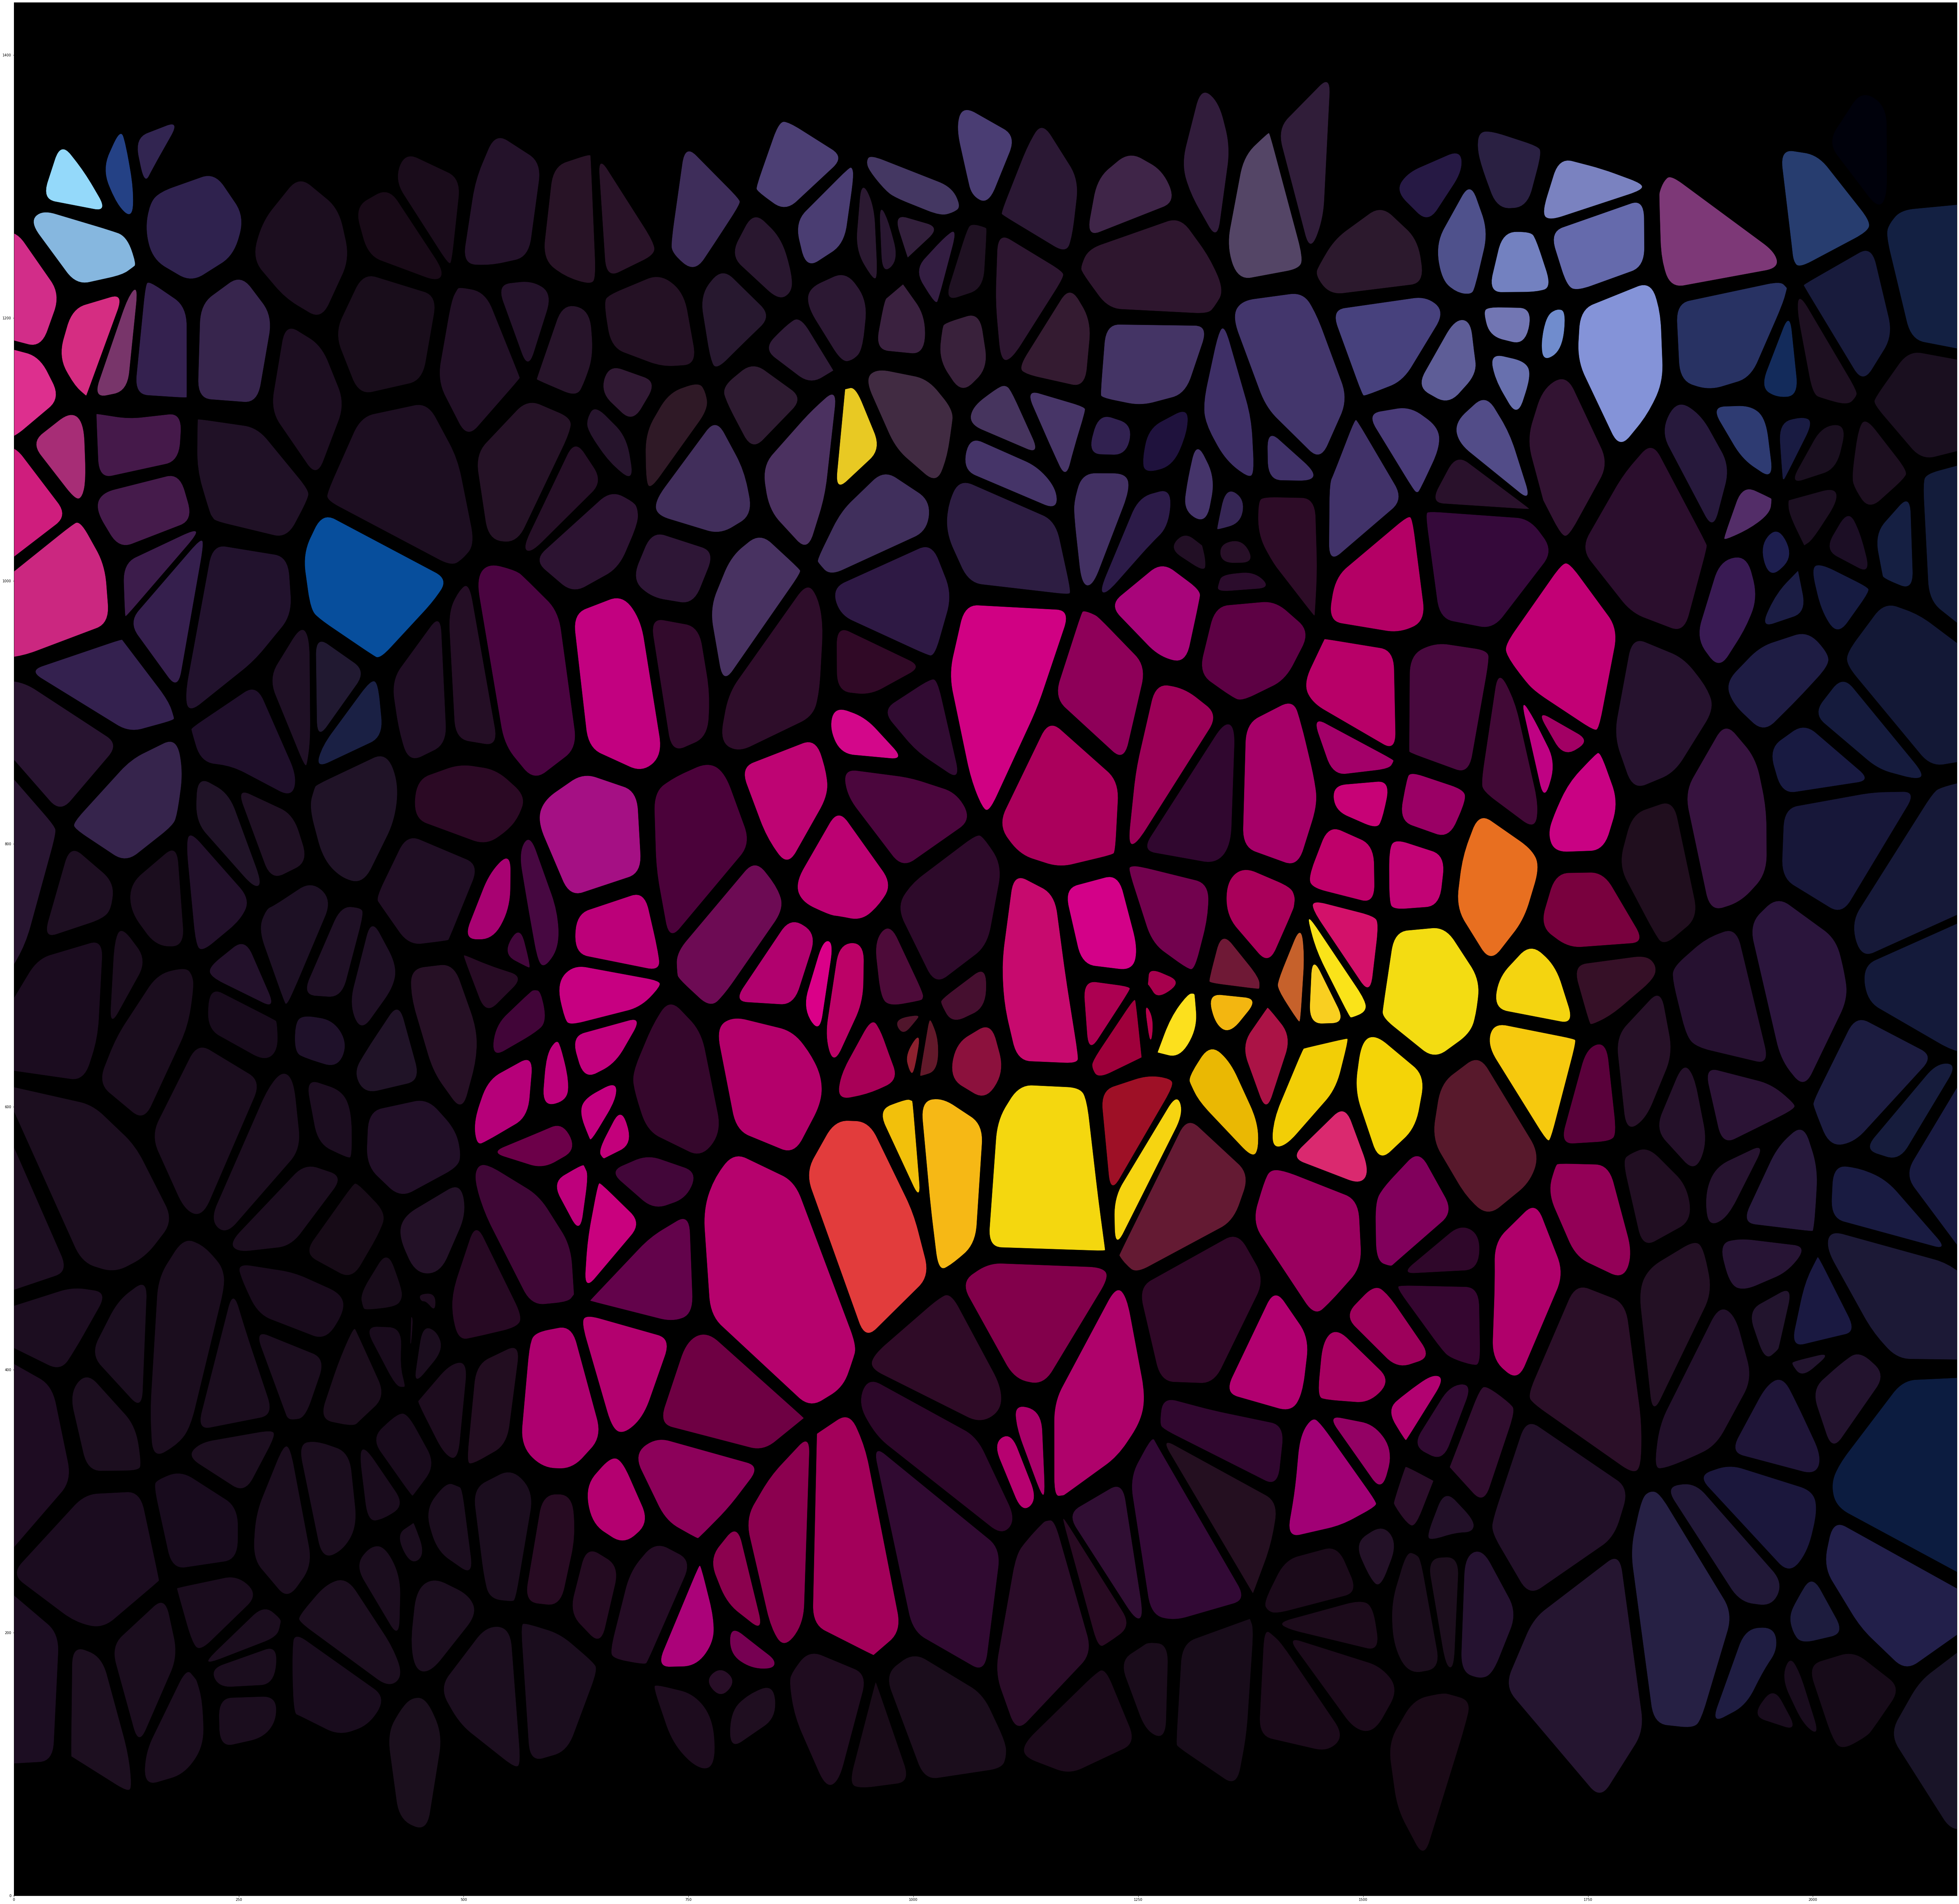

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from matplotlib import patches, path
from scipy.spatial import Voronoi, voronoi_plot_2d
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

plt.rcParams["figure.figsize"] = (100,100)


def shrink(polygon, pad):
    center = np.mean(polygon, axis=0)
    resized = np.zeros_like(polygon)
    for ii, point in enumerate(polygon):
        vector = point - center
        unit_vector = vector / np.linalg.norm(vector)
        resized[ii] = point - pad * unit_vector
    return resized


class RoundedPolygon(patches.PathPatch):
    # https://stackoverflow.com/a/66279687/2912349
    def __init__(self, xy, pad, **kwargs):
        p = path.Path(*self.__round(xy=xy, pad=pad))
        super().__init__(path=p, **kwargs)

    def __round(self, xy, pad):
        n = len(xy)

        for i in range(0, n):

            x0, x1, x2 = np.atleast_1d(xy[i - 1], xy[i], xy[(i + 1) % n])

            d01, d12 = x1 - x0, x2 - x1
            l01, l12 = np.linalg.norm(d01), np.linalg.norm(d12)
            u01, u12 = d01 / l01, d12 / l12

            x00 = x0 + min(pad, 0.5 * l01) * u01
            x01 = x1 - min(pad, 0.5 * l01) * u01
            x10 = x1 + min(pad, 0.5 * l12) * u12
            x11 = x2 - min(pad, 0.5 * l12) * u12

            if i == 0:
                verts = [x00, x01, x1, x10]
            else:
                verts += [x01, x1, x10]

        codes = [path.Path.MOVETO] + n*[path.Path.LINETO, path.Path.CURVE3, path.Path.CURVE3]

        verts[0] = verts[-1]

        return np.atleast_1d(verts, codes)



img = cv2.imread("jap.jpg")
img = img[:, :, [2, 1, 0]]
print(img.shape[:2])

n = 500
max_y = img.shape[0]
max_x = img.shape[1]
print("max x, max y",max_x, max_y)

points = np.c_[np.random.randint(0, max_x, size=n),
               np.random.randint(0, max_y, size=n)]

    # add 4 distant dummy points
points = np.append(points, [[2 * max_x, 2 * max_y],
                            [   -max_x, 2 * max_y],
                            [2 * max_x,    -max_y],
                            [   -max_x,    -max_y]], axis = 0)

    # compute Voronoi tesselation
vor = Voronoi(points)

pad_amount = max(max_x, max_y) / 200
rounding_amount = max(max_x, max_y) / 150

print("min_shrink", max(max_x, max_y) / 200)
fig, ax = plt.subplots()
for region in vor.regions:
    if region and (not -1 in region):
        polygon = np.array([vor.vertices[i] for i in region])
        resized = shrink(polygon, pad_amount)
        #print(polygon)
        #print(np.mean(polygon, axis=0))
        x, y = np.mean(polygon, axis=0).astype(int)
        
        x = max(0, min(x, max_x - 1))
        y = max(0, min(y, max_y - 1))
        
        #print(RoundedPolygon(resized, 0.2, color=img[x,y]))
 
        ax.add_patch(RoundedPolygon(resized, rounding_amount, color=img[y,x] / 255))#plt.cm.Reds(0.5 + 0.5*np.random.rand())))

        #break
            

ax.axis([0, max_x, 0, max_y])
#ax.axis('off')
ax.set_facecolor('black')
ax.add_artist(ax.patch)
ax.patch.set_zorder(-1)
plt.savefig("ECCOLA.jpg", bbox_inches='tight', pad_inches=0)


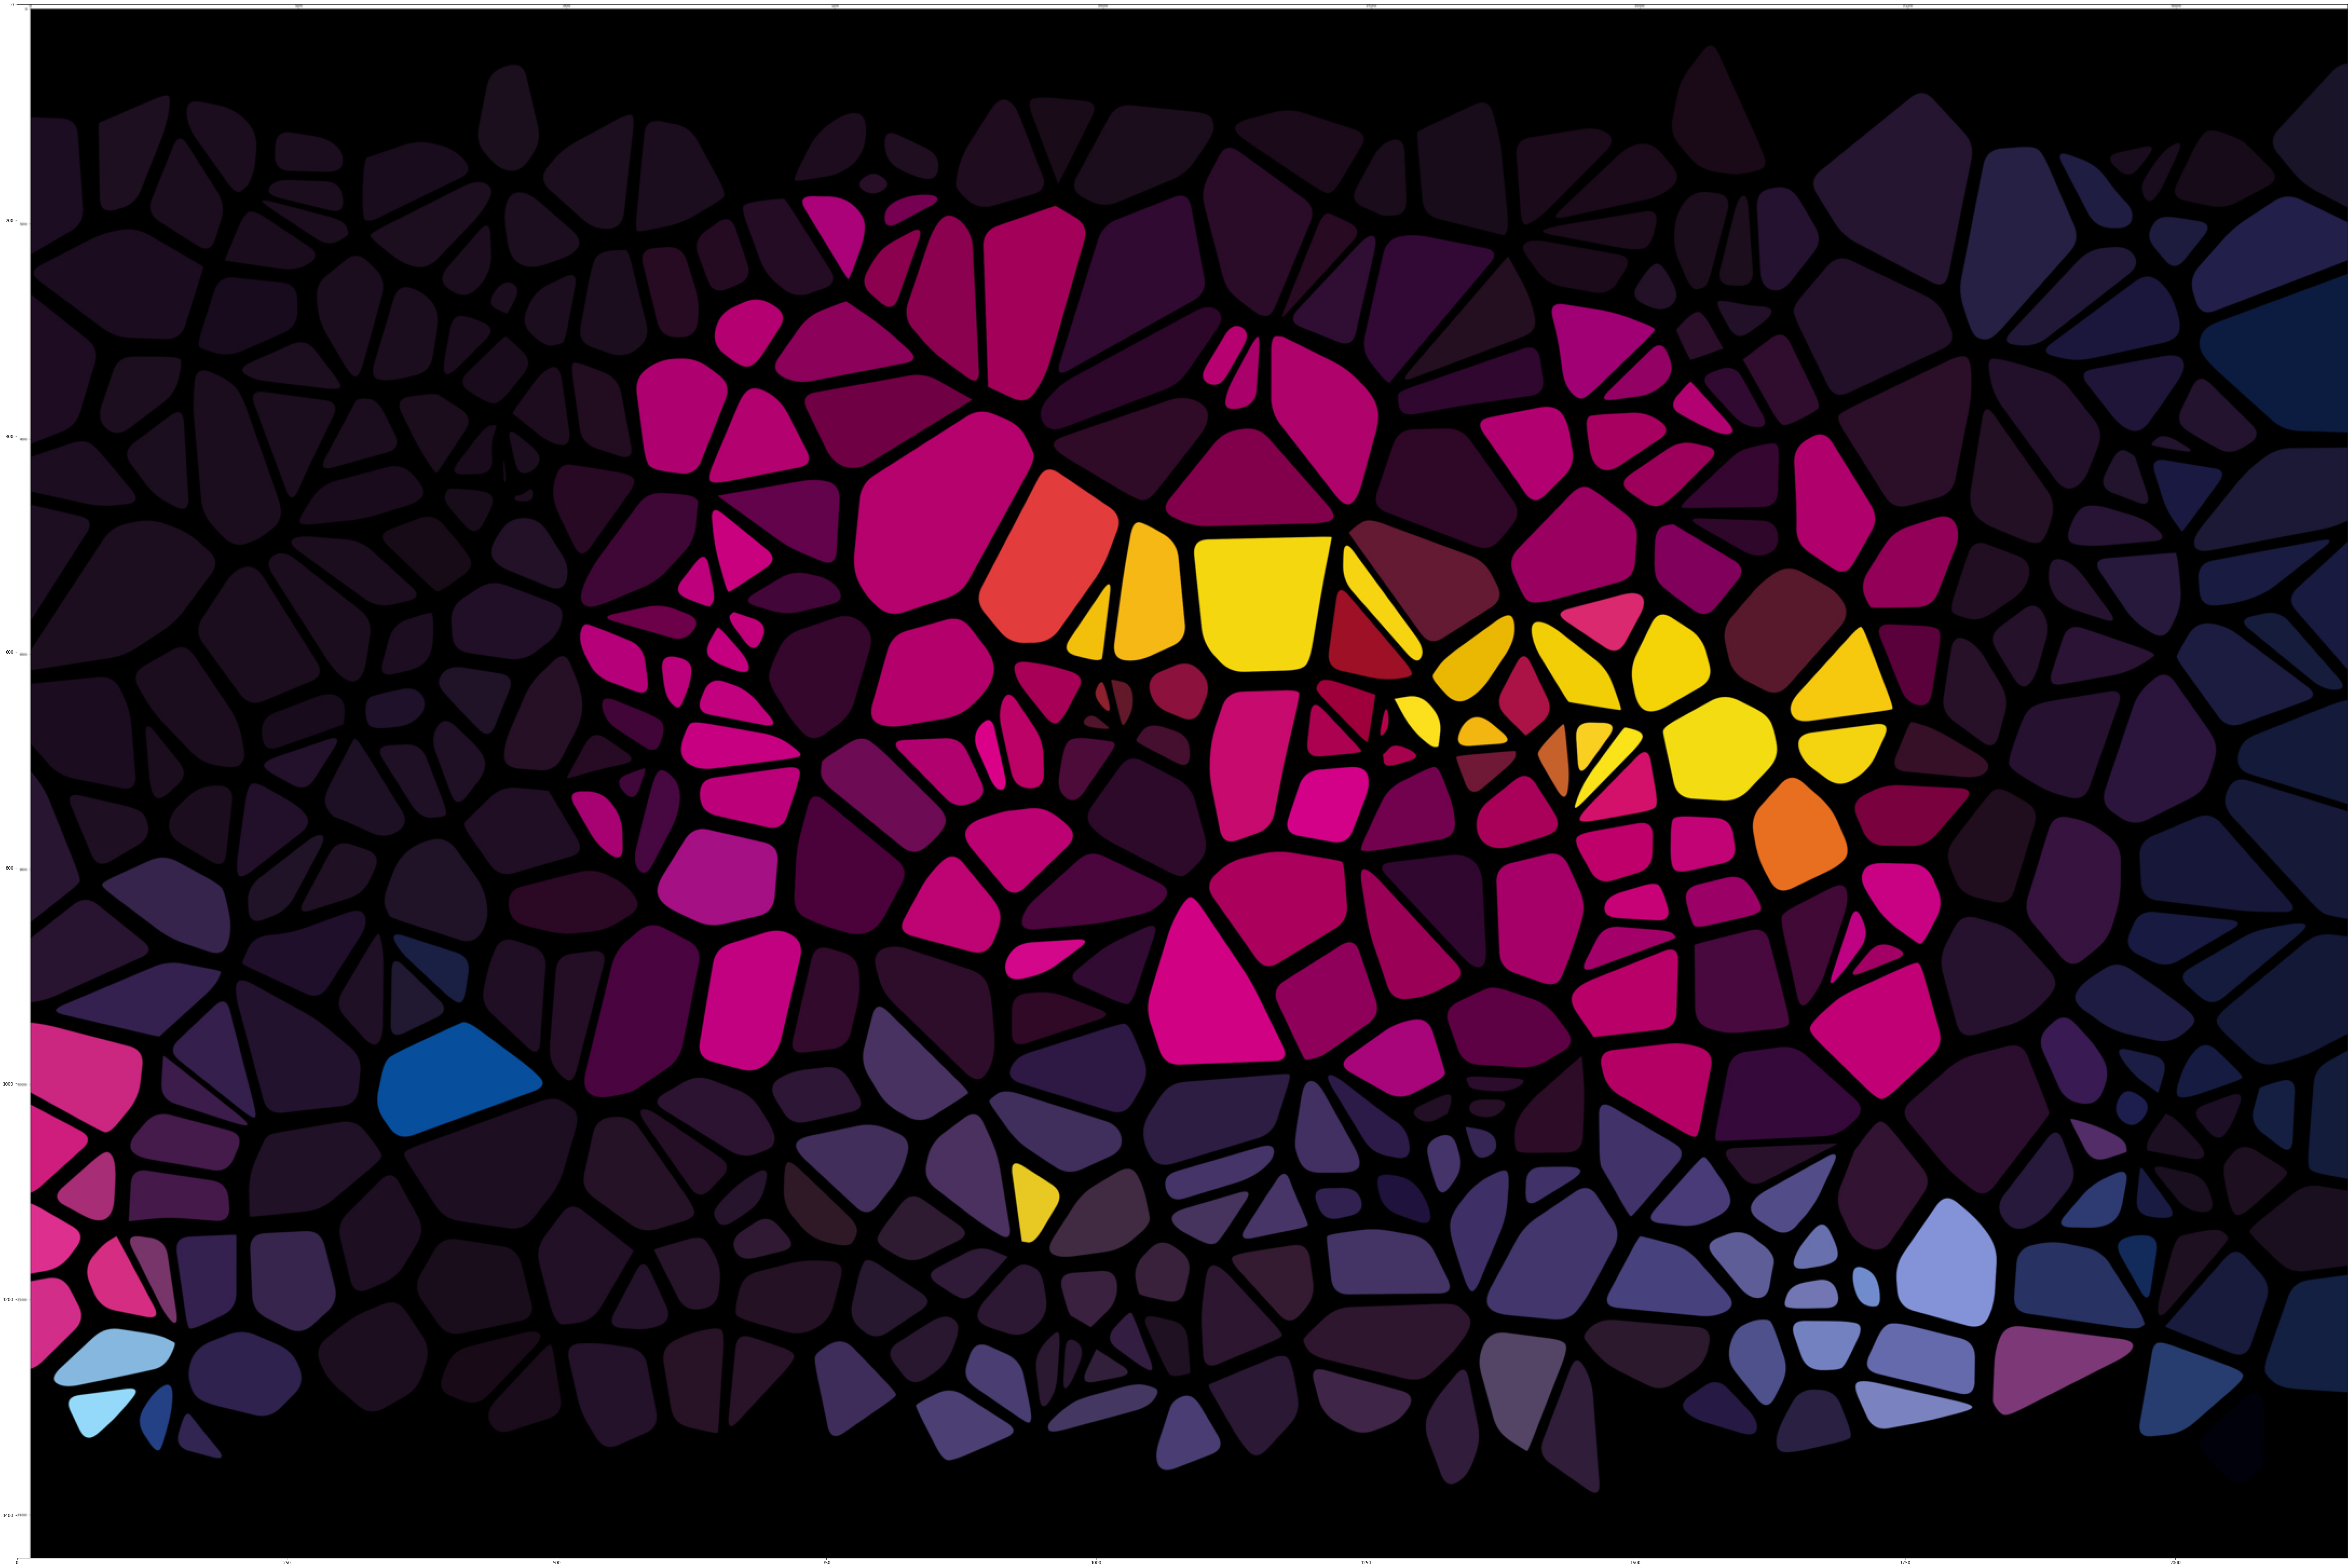

In [24]:
img = Image.open('ECCOLA.jpg')
img = img.resize((max_x, max_y))
img = ImageOps.flip(img)
img.save("ECCOLA.jpg")
plt.imshow(img)